In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pickle

from ta.momentum import rsi, stoch, stoch_signal
from ta.volatility import average_true_range
from ta.volume import on_balance_volume

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.layers import MaxPooling1D, Flatten, Conv1D
from keras.wrappers.scikit_learn import KerasRegressor

2024-08-29 23:05:14.057394: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Preprocessing

In [2]:
df_nasdaq = pd.read_csv('df_nasdaq.csv')
df_sp500 = pd.read_csv('df_sp500.csv')
df_dji = pd.read_csv('df_dji.csv')

stocks = {'df_nasdaq': df_nasdaq, 'df_sp500': df_sp500, 'df_dji': df_dji}

for name, df in stocks.items():
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    filename = f"{name}.csv"
    df.to_csv(filename, index=False)
    print(f'Shape of {name}: {df.shape}')

Shape of df_nasdaq: (1372, 19)
Shape of df_sp500: (1372, 19)
Shape of df_dji: (1372, 19)


In [26]:
feature = ['Open', 'High', 'Low', 'Volume', 'DailyReturn', 'Adj Close',
           'MA_10', 'MA_20', 'MA_50', 'EMA_100', 'EMA_200', 
           'Volatility_bbh', 'Volatility_bbl', 'MACD', 'RSI', 'ATR','OBV']
target = 'Close'

# Result of XGBoost feature selection, according to 7600_code_XGB_part
feature_xgb_nasdaq = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'Volatility_bbl']
feature_xgb_sp500 = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'MA_20']
feature_xgb_dji = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'OBV']

df_nasdaq_preprocessed = df_nasdaq[[target] + feature_xgb_nasdaq]
df_sp500_preprocessed = df_sp500[[target] + feature_xgb_sp500]
df_dji_preprocessed = df_dji[[target] + feature_xgb_dji]

In [27]:
def split_data(stock):
    stock = stock.to_numpy()
    test_set_size = int(np.round(0.2 * len(stock)))
    val_set_size = int(np.round(0.2 * len(stock)))
    train_set_size = len(stock) - test_set_size - val_set_size
    
    train = stock[:train_set_size, :]
    val = stock[train_set_size: train_set_size+val_set_size, :]
    test = stock[train_set_size+val_set_size:, :]

    return (train, val, test)

train, val, test = split_data(df_dji_preprocessed)

In [28]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(f'Shape of scaled training Set: {scaled_train.shape}')
print(f'Shape of scaled training Set: {scaled_val.shape}')
print(f'Shape of scaled testing Set: {scaled_test.shape}')

Shape of scaled training Set: (824, 7)
Shape of scaled training Set: (274, 7)
Shape of scaled testing Set: (274, 7)


In [29]:
def createXY(dataset,lookback):
    dataX = []
    dataY = []
    for i in range(lookback, len(dataset)):
            dataX.append(dataset[i - lookback:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

lookback = 30

X_train, y_train = createXY(scaled_train,lookback)
X_val, y_val = createXY(scaled_val,lookback)
X_test, y_test = createXY(scaled_test,lookback)

print(f"shape of X_train:{np.shape(X_train)}, shape of y_train:{np.shape(y_train)}")
print(f"shape of X_train:{np.shape(X_val)}, shape of y_train:{np.shape(y_val)}")
print(f"shape of X_test:{np.shape(X_test)}, shape of y_test:{np.shape(y_test)}")

shape of X_train:(794, 30, 7), shape of y_train:(794,)
shape of X_train:(244, 30, 7), shape of y_train:(244,)
shape of X_test:(244, 30, 7), shape of y_test:(244,)


## Model - GRU

In [30]:
model = Sequential()
model.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

# Define a custom callback to save the model every 50 epochs
def save_every_n_epochs(epoch, logs):
    if (epoch + 1) % 50 == 0:  # Save at 50, 100, 150, ..., 500 epochs
        filepath = f'gru/dji_gru_epoch_{epoch + 1:03d}.h5'
        model.save(filepath)
        print(f'\nModel saved at {filepath}')

# Convert the function to a Keras callback
save_callback = LambdaCallback(on_epoch_end=save_every_n_epochs)


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=500, batch_size=16, callbacks=[save_callback])
with open('gru/dji_gru_training_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30, 32)            3936      
                                                                 
 dropout_4 (Dropout)         (None, 30, 32)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,305
Trainable params: 10,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================]

In [31]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

446

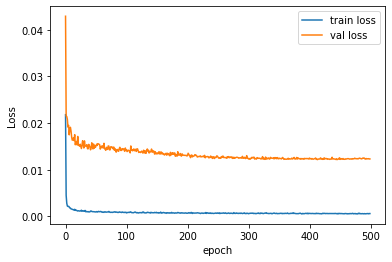

In [32]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

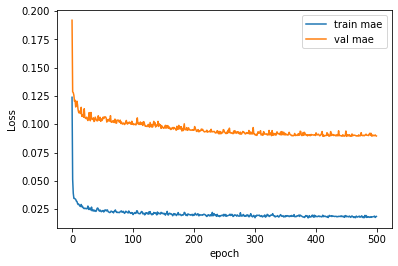

In [33]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model - GRU - Plot

In [34]:
# The minimized val-loss epoch is 446, so that load weights of epoch_300 to predict.
model = load_model('gru/dji_gru_epoch_450.h5')

y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'gru': y_pred_inversed})
results_df.to_csv('gru/dji_gru_predictions.csv', index=False)

8/8 [==============================] - 1s 2ms/step


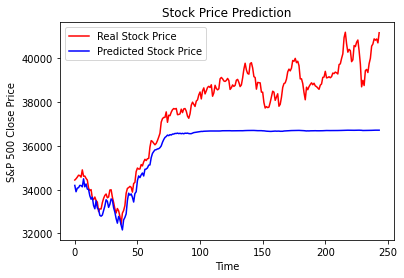

In [35]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

### Model - GRU - Error Metrics

In [36]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 4165060.724648196
Mean Absolute Error (MAE): 1710.8041992187505
R-squared (R²): 0.1900952184018012


## Model - SRU

In [37]:
class SRUCell(layers.Layer):
    def __init__(self, units, **kwargs):
        super(SRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = self.units  # Define the state size

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units * 3),
                                 initializer='glorot_uniform',
                                 name='W')
        self.U = self.add_weight(shape=(self.units, self.units * 2),
                                 initializer='orthogonal',
                                 name='U')
        self.b = self.add_weight(shape=(self.units * 3,),
                                 initializer='zeros',
                                 name='b')
        # New weight for transforming input to match hidden state dimension
        self.V = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 name='V')
        super(SRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]
        x_W = tf.matmul(inputs, self.W) + self.b
        z, f, r = tf.split(x_W, 3, axis=-1)
        
        h_U = tf.matmul(h_prev, self.U)
        z_U, f_U = tf.split(h_U, 2, axis=-1)
        
        f = tf.sigmoid(f + f_U)
        r = tf.sigmoid(r)
        z = tf.tanh(z + z_U)
        
        # Transform inputs to match the hidden state dimension
        inputs_transformed = tf.matmul(inputs, self.V) 
        h = f * h_prev + (1 - f) * z
        h = r * h + (1 - r) * inputs_transformed
        
        return h, [h]

    def get_config(self):
        config = super(SRUCell, self).get_config()
        config.update({
            'units': self.units,
        })
        return config

class SRU(layers.RNN):
    def __init__(self, units, **kwargs):
        cell = SRUCell(units)
        super(SRU, self).__init__(cell, **kwargs)

    def get_config(self):
        config = super(SRU, self).get_config()
        config.update({
            'units': self.cell.units,
        })
        return config

In [38]:
model = Sequential()

model.add(SRU(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.2))
model.add(SRU(units=32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
model.summary()

# Define a custom callback to save the model every 50 epochs
def save_every_n_epochs(epoch, logs):
    if (epoch + 1) % 50 == 0:  # Save at 50, 100, 150, ..., 500 epochs
        filepath = f'sru/dji_sru_epoch_{epoch + 1:03d}.h5'
        model.save(filepath)
        print(f'\nModel saved at {filepath}')

# Convert the function to a Keras callback
save_callback = LambdaCallback(on_epoch_end=save_every_n_epochs)


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=500, batch_size=16, callbacks=[save_callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sru_2 (SRU)                 (None, 30, 32)            3040      
                                                                 
 dropout_6 (Dropout)         (None, 30, 32)            0         
                                                                 
 sru_3 (SRU)                 (None, 32)                6240      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,313
Trainable params: 9,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] -

In [39]:
with open('sru/dji_sru_training_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [40]:
val_loss = history.history['val_loss']
min_val_loss_epoch = val_loss.index(min(val_loss)) + 1 
min_val_loss_epoch

36

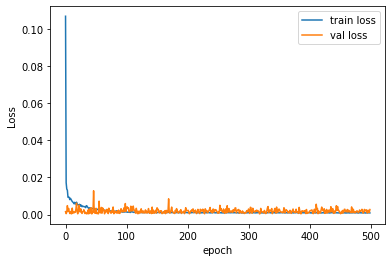

In [41]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

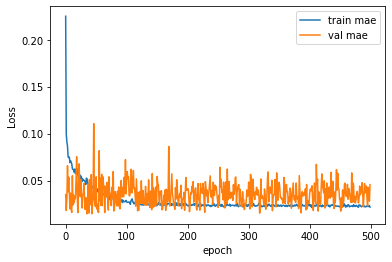

In [42]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### Model - SRU - Plot

In [43]:
# The minimized val-loss epoch is 238, so that load weights of epoch_250 to predict.
# However, cannot load model from .h5 file,
# just save predicted data and training history.

y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'gru': y_pred_inversed})
results_df.to_csv('sru/dji_sru_predictions.csv', index=False)

8/8 [==============================] - 0s 9ms/step


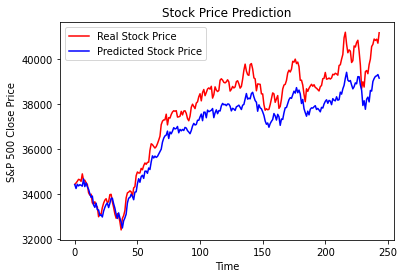

In [44]:
plt.plot(y_test_inversed, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_inversed, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [45]:
def calculate_error_metrics(y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

    return

calculate_error_metrics(y_test_inversed, y_pred_inversed)

Mean Squared Error (MSE): 900839.722408577
Mean Absolute Error (MAE): 833.3376024590168
R-squared (R²): 0.8248298291751974
